In [1]:
import sys
#print(sys.version)

import matplotlib.pyplot as plt
#%config BackendInline.figure_format='svg'

plt.style.use(['seaborn-paper', 'seaborn-white', 'seaborn-ticks'])
# plt.matplotlib.rcParams['figure.dpi'] = 120
# plt.matplotlib.rcParams['savefig.dpi'] = 120

import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager
import mlgrad.avragg as avragg


from mlgrad import averager_it, averager_fg, fg, fg_rud, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk

In [2]:
def sigma_neuron_layer(n_input, n_output):
    outfunc = func.Arctang()
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [3]:
def create_nn(n_hidden):
    n_input = X.shape[1]
    layer1 = sigma_neuron_layer(n_input, n_hidden)

    body = model.FFNetworkModel()
    body.add(layer1)

    head = model.LinearModel(n_hidden)
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

## Dataset 1

In [4]:
def gendataset(N=1000, m=3, dy=0.2):
    X = np.random.random(size=(N, m))
    X = 2. * X - 1.
    X = 2. * X
    Y0 = np.array([np.sum(x*x)**(1./3.) for x in X])
    Y = Y0 + dy * (2*np.random.random(N) - 1)
    return X, Y

def add_outliers(X, Y, q=0.1, DY=30.):
    N = len(Y)
    M = int(q*N)
    I1 = np.random.randint(0, N-1, M)
    Y1 = Y.copy()
    for i1 in I1:
        Y1[i1] = DY
    return Y1
    

In [5]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
#loss_func_hub = loss.ErrorLoss(func.Huber(0.1))

In [6]:
result = {}

In [7]:
n_hidden = 20
Q = 45
q = Q / 100.

In [8]:
X, Y = gendataset()
X_t, Y_t = gendataset(dy=0)
Y_o = add_outliers(X, Y, q)

In [9]:
ffnn0 = create_nn(n_hidden)
ffnn0.param[:] = np.random.random(size=ffnn0.n_param)
ffnn1 = create_nn(n_hidden)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)
ffnn2 = create_nn(n_hidden)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)
ffnn3 = create_nn(n_hidden)
ffnn3.param[:] = np.random.random(size=ffnn3.n_param)

Completed? True


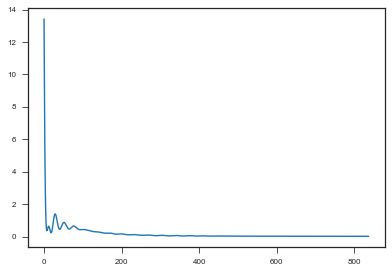

In [10]:
er0 = erisk(X, Y, ffnn0, loss_func_sq)
fg0 = erm_fg(er0, h=0.05, tol=1.0e-7, verbose=0, n_iter=1000)
print("Completed?", fg0.completed)

plt.plot(fg0.lvals)
plt.show()

Completed? True


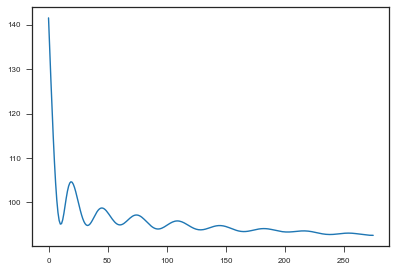

In [11]:
er1 = erisk(X, Y_o, ffnn1, loss_func_sq)
fg1 = erm_fg(er1, h=0.05, tol=1.0e-6, verbose=0, n_iter=1000)
print("Completed?", fg1.completed)

plt.plot(fg1.lvals)
plt.show()

Completed? True


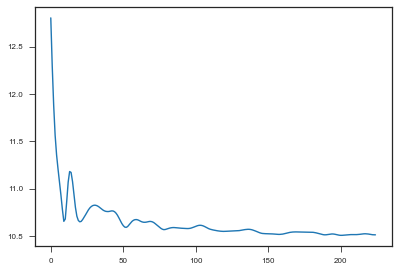

In [12]:
er2 = erisk(X, Y_o, ffnn2, loss_func_abs)
fg2 = erm_fg(er2, h=0.05, tol=1.0e-6, verbose=0, n_iter=1000)
print("Completed?", fg2.completed)

plt.plot(fg2.lvals)
plt.show()

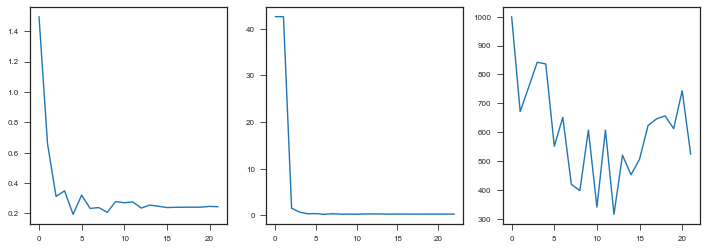

In [13]:
d_irgd3={}
def irgd3_callback(irgd3, d=d_irgd3):
    d.setdefault('qval', []).append(irgd3.weights.qval)

er3 = erisk(X, Y_o, ffnn3, loss_func_sq)
fg3 = fg(er3, h=0.05, tol=1.0e-7, n_iter=1000)
alpha = 1-q
avg3 = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.0001)))
avr3 = avragg.WMAverage(avg3)
wg3 = weights.MWeights(avg3, er3)
irgd3 = erm_irgd(fg3, wg3, n_iter=22, verbose=0, callback=irgd3_callback)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(irgd3.lvals)
plt.subplot(1,3,2)
plt.plot(d_irgd3['qval'])
plt.subplot(1,3,3)
plt.plot(irgd3.n_iters)
plt.show()

In [14]:
result[Q] = {
    'nn':(
        ffnn0, ffnn1, ffnn2, ffnn3),
    'title':(
        'AM / Squared Errors / without outliers',
        'AM / Squared Errors / %s%% outliers' % Q,
        'AM / Absolute Errors / %s%% outliers' % Q,
        'WM$_{%.2f}$ / Square Errors / %s%% outliers' % (alpha, Q) ),
    'b':0.1
}

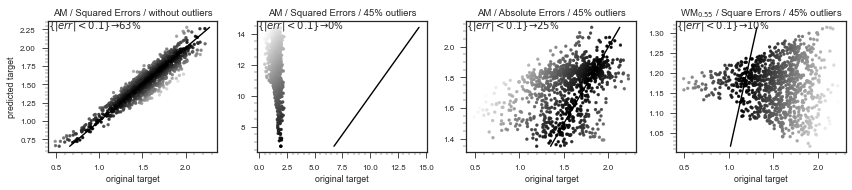

In [15]:
m_q = len(result)
plt.figure(figsize=(12.0, m_q * 2.75))
for j, Q in enumerate(result):
    for i in range(4):
        current = result[Q]
        b = current['b']
        plt.subplot(m_q, 4, 4*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array([_ffnn(x) for x in X_t])
        title = current['title'][i]
        plt.title(title)
        V = np.abs(Y_t-Y1)
        I = np.argsort(V)
        I = I[::-1]
        Y2 = [np.min(Y1), np.max(Y1)]
        plt.plot(Y2, Y2, c='k')
        plt.scatter(Y_t[I], Y1[I], c=V[I], s=9, cmap=plt.cm.gray)
        c = sum(V < b) / len(V) * 100
        y_min, y_max = plt.xlim()
        plt.text(y_min, Y1.max(), r'$\{|err|<%.1f\}\to%s$%%' % (b, int(c)))
        if i == 0:
            plt.ylabel("predicted target")
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2018_dataset_1_%s.pdf" % n_hidden)
plt.show()